In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

In [2]:
# importing data from the file A2Q3.csv
X = np.loadtxt('A2Q3.csv',delimiter=',',dtype='float')

In [3]:
def start(X,n_components,max_iter,tol):
#     need to also return iteration and corresponding log values
    graph = []
#     X.shape returns a tuple so we intialize it in this way
    n_samples,n_features = X.shape
    alpha = np.full(n_components,1/n_components)
    random_indices = np.random.choice(n_samples, n_components, replace=False)
    
    mu = X[random_indices]
    
    #initialising cov matrix
    sigma = np.zeros((n_components,n_features,n_features))
    for k in range(n_components):
        sigma[k]=np.eye(n_features)
#     initially we take -np.inf as loglikelihood value and then try to maximise it
    log_likelihood = -np.inf
    for i in range(max_iter):
        temp = [i+1]
        #calculate soft labels or probability of that x being part of each cluster.
        responsibilities = compute_probabilities(X,n_components,mu,sigma,alpha)
        mu,sigma,alpha = update_parameters(X,n_components,responsibilities,mu,sigma,alpha)
        likelihoods = np.zeros((X.shape[0],n_components))
        #for each component we calculate normal and then find each likelihood.
        for k in range(n_components):
            mvn = multivariate_normal(X,n_components,mu[k],sigma[k],alpha)
            likelihoods[:,k] = alpha[k]*mvn
            
        log_likelihood_new = np.log(likelihoods.sum(axis = 1)).sum()
        
#         if change is less than defined epsilon or tol then we come out of the process and declare the clusters.
        if(abs(log_likelihood_new-log_likelihood)<=tol):
            break
        else:
            log_likelihood = log_likelihood_new
        temp.append(log_likelihood)
#         loglikelihood graph formation
        graph.append(temp)
    labels = np.argmax(responsibilities, axis=1)
    graph = np.array(graph)
#     soft labels and graph returning
    return labels,graph,mu

In [4]:
def compute_probabilities(X,n_components,mu,sigma,alpha):
    # Compute probabilities of each data point belonging to each component
    likelihoods = np.zeros((X.shape[0],n_components))
    #first we calculate the normal and then find likelihood to compute partial probabilities 
    for k in range(n_components):
        mvn = multivariate_normal(X,n_components,mu[k],sigma[k],alpha)
        #k probabilities that is probability of this point being each of k clusters.
        likelihoods[:, k] = alpha[k] * mvn
    responsibilities = likelihoods / likelihoods.sum(axis=1, keepdims=True)
    return responsibilities

In [5]:
def multivariate_normal(X,n_components,mu,sigma,alpha):
    #getting postprobability
    n_features = X.shape[1]
    det = np.linalg.det(sigma)
    inv = np.linalg.pinv(sigma)
    #given formula
    norm_const = 1/(np.sqrt((2 * np.pi)**n_features * det))
    x_mu = X-mu
    exponent = -0.5 * np.einsum('ij, ij -> i', X - mu, np.dot(inv, (X - mu).T).T)
    #sending the probab
    return norm_const*np.exp(exponent)


In [6]:
def update_parameters(X,n_components,responsibilities,mu,sigma,alpha):
    n_samples,n_features = X.shape
    alpha = responsibilities.mean(axis = 0)
    #after we assign those soft probabilites we need to re compute all the probabilities to continue this EM step
    for k in range(n_components):
        mu[k] =  (responsibilities[:, k, np.newaxis] * X).sum(axis=0) / responsibilities[:, k].sum()
    #after that means are updated we update covariance and the pis or alpha
    for k in range(n_components):
        x_mu = X[:, np.newaxis, :] - mu
        x_mu_res = x_mu * responsibilities[:, :, np.newaxis]
        sigma[k] = np.dot(x_mu_res[:, k, :].T, x_mu_res[:, k, :]) / responsibilities[:, k].sum()
    return mu,sigma,alpha  

In [8]:
y,graph,means = start(X,3,100,0.001)


In [9]:
print(len(y))

400


In [10]:
def log_plot(graph):
    X = list(graph[:,0])
    Y = list(graph[:,1])
    plt.plot(X,Y)
    plt.xlabel("Iteration")
    plt.ylabel("Log value")
    plt.title("log-likelihood")
    plt.show()

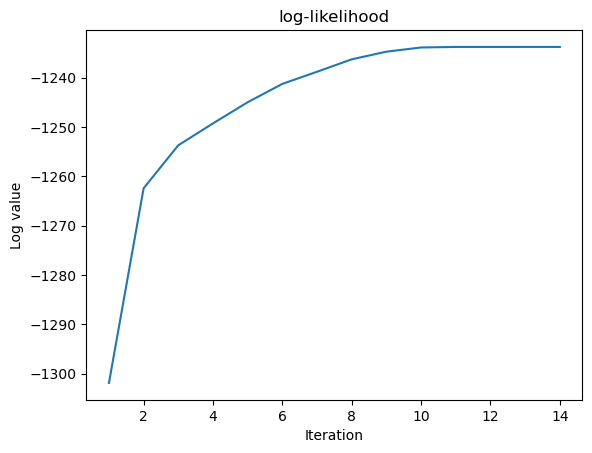

In [11]:
log_plot(graph)

In [12]:
def scatter(graph):
    X = list(graph[:,0])
    Y = list(graph[:,1])
    plt.scatter(X, Y)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("scatter plot")
    plt.show()
    

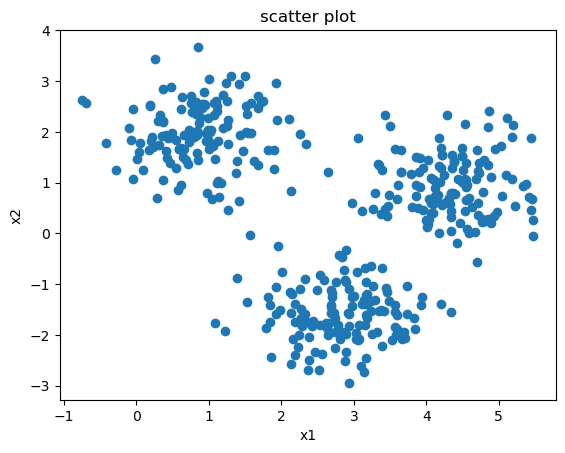

In [13]:
scatter(X)

# Part B

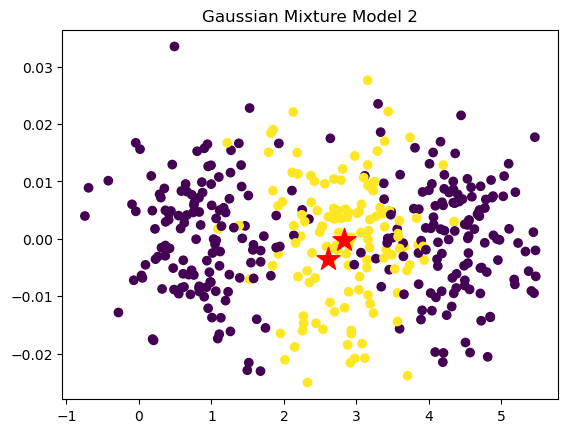

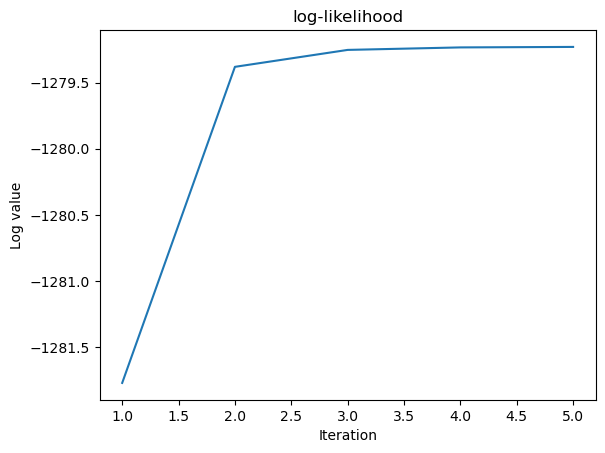

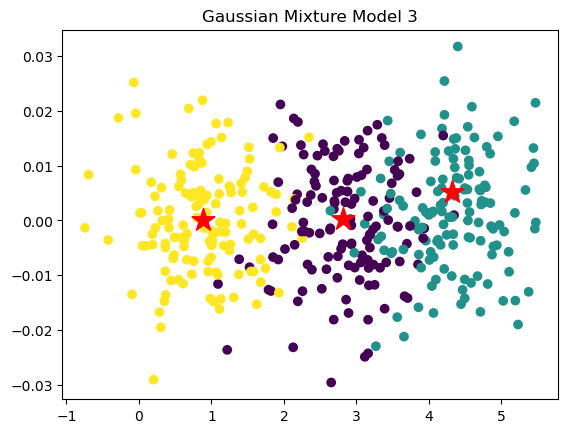

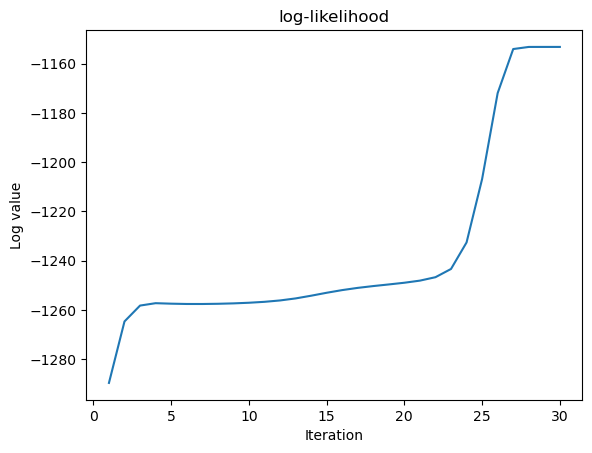

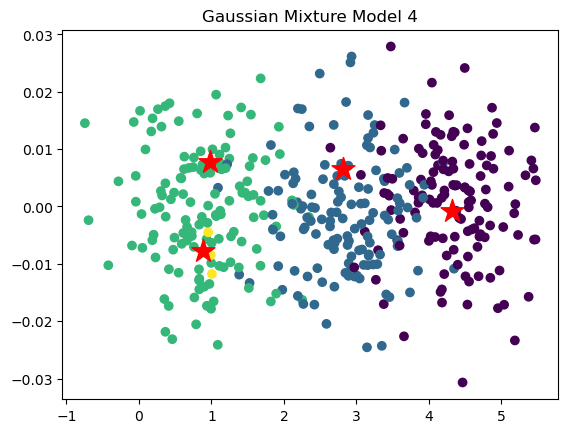

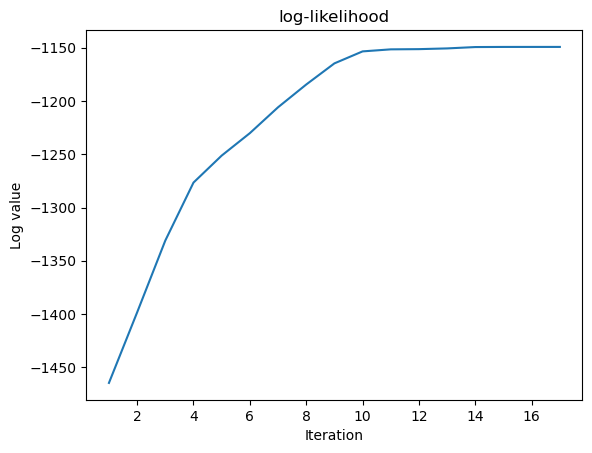

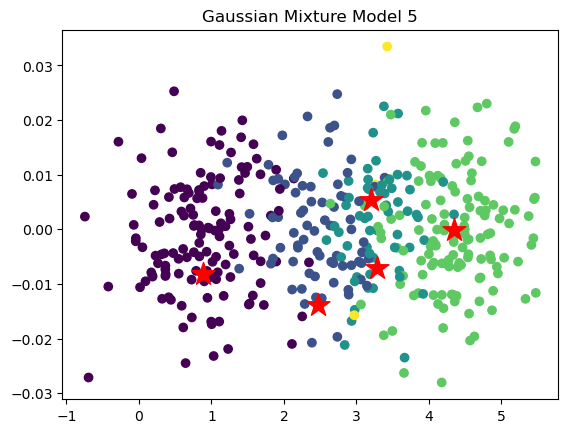

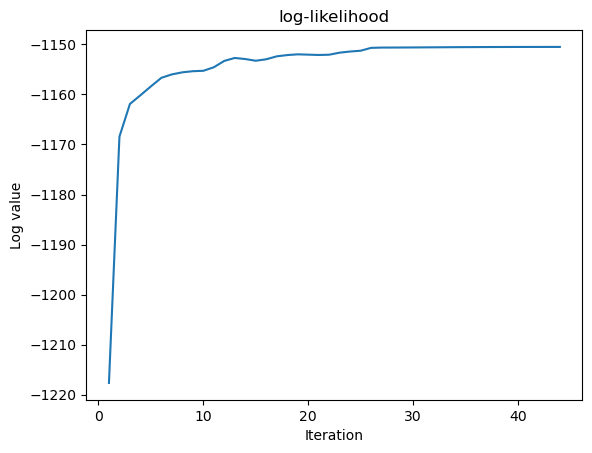

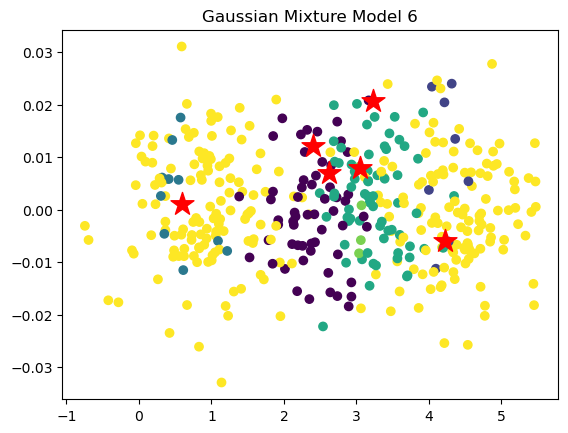

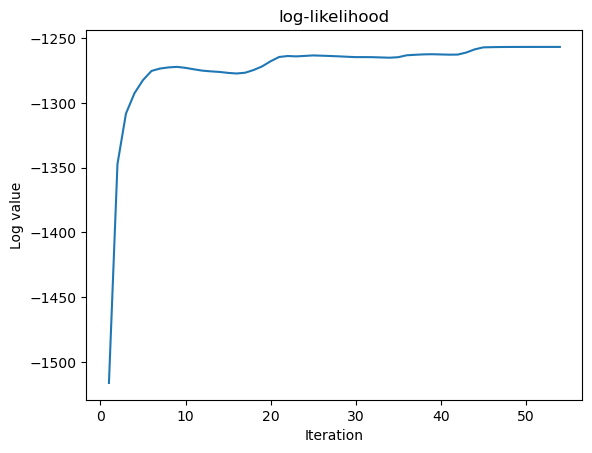

In [14]:
k = [2,3,4,5,6]
logValues = []
for i in k:
    labels,graph,means = start(X,i,100,0.001)
    logValues.append(graph[-1][-1])
    plt.scatter(X[:, 0], np.random.normal(0, 0.01, len(X)), c=labels, cmap='viridis')
    plt.scatter(means[:, 0], np.random.normal(0, 0.01, len(means)), marker='*', s=300, linewidth=1, c='red')
    plt.title('Gaussian Mixture Model '+str(i))
    plt.show()
    log_plot(graph)

# Part C

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score



# Define a range of values for the number of components K
Ks = range(2, 10)

# Initialize lists to store the Silhouette scores and GMMs for each K
sil_scores = []
gmms = []

# Fit a GMM for each value of K and compute the Silhouette score
for K in Ks:
    gmm = GaussianMixture(n_components=K)
    gmm.fit(X)
    gmms.append(gmm)
    labels = gmm.predict(X)
    sil_score = silhouette_score(X, labels)
    sil_scores.append(sil_score)

# Choose the value of K that maximizes the Silhouette score
best_K = Ks[np.argmax(sil_scores)]
best_gmm = gmms[np.argmax(sil_scores)]

In [17]:
print(best_gmm)

GaussianMixture(n_components=3)


In [ ]:
# The silhouette score is a measure of how well-separated the clusters are in a clustering solution, taking into account both the distance between points within a cluster and the distance between points in different clusters.

# To compute the silhouette score for a particular clustering solution, we first compute the average distance between a point and all other points in the same cluster, which we denote as a(i). This gives us a measure of how well the point fits into its own cluster. We then compute the average distance between a point and all other points in the nearest neighboring cluster (i.e., the cluster with the smallest average distance to the point that is not the same as the point's cluster), which we denote as b(i). This gives us a measure of how well the point fits into its neighboring cluster.

# Finally, we compute the silhouette score for the clustering solution as the average silhouette score across all points:

# s(i) = (b(i) - a(i)) / max(a(i), b(i))

# The silhouette score ranges from -1 to +1, with higher values indicating better clustering solutions. A score of +1 indicates that a point is well-clustered and far away from other clusters, while a score of -1 indicates that a point is poorly clustered and closer to points in other clusters. A score of 0 indicates that a point is on the boundary between two clusters.

# To compute the silhouette score for a clustering solution with multiple clusters, we compute the average silhouette score across all points in all clusters. We can also compute the average silhouette score separately for each cluster to get a sense of how well-separated the clusters are.

# The overall silhouette score for a clustering solution is higher when the clusters are well-separated and distinct, and lower when the clusters are overlapping or poorly-separated. Therefore, we can use the silhouette score to evaluate the quality of different clustering solutions and to choose the number of clusters that provides the best separation between the data points.